# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [2]:
pip install tensorflow keras numpy matplotlib opencv-python pillow scikit-learn jupyter

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.75.1-cp312-cp312-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cach

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.1 which is incompatible.


In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [13]:
import cv2
import imutils
from matplotlib import pyplot as plt


In [14]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

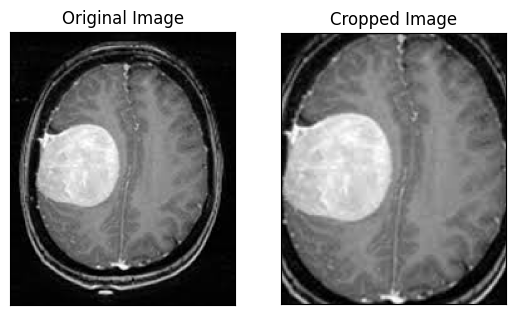

In [15]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [18]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)

            if image is None:
                print(f"Warning: Unable to read image {filepath}. Skipping.")
                continue

            try:
                image = crop_brain_contour(image, plot=False)
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.
                X.append(image)
                y.append([1] if os.path.basename(directory).lower() == 'yes' else [0])
            except Exception as e:
                print(f"Error processing image {filepath}: {e}")
                continue
                
    X = np.array(X)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [19]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1724
X shape is: (1724, 240, 240, 3)
y shape is: (1724, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [20]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

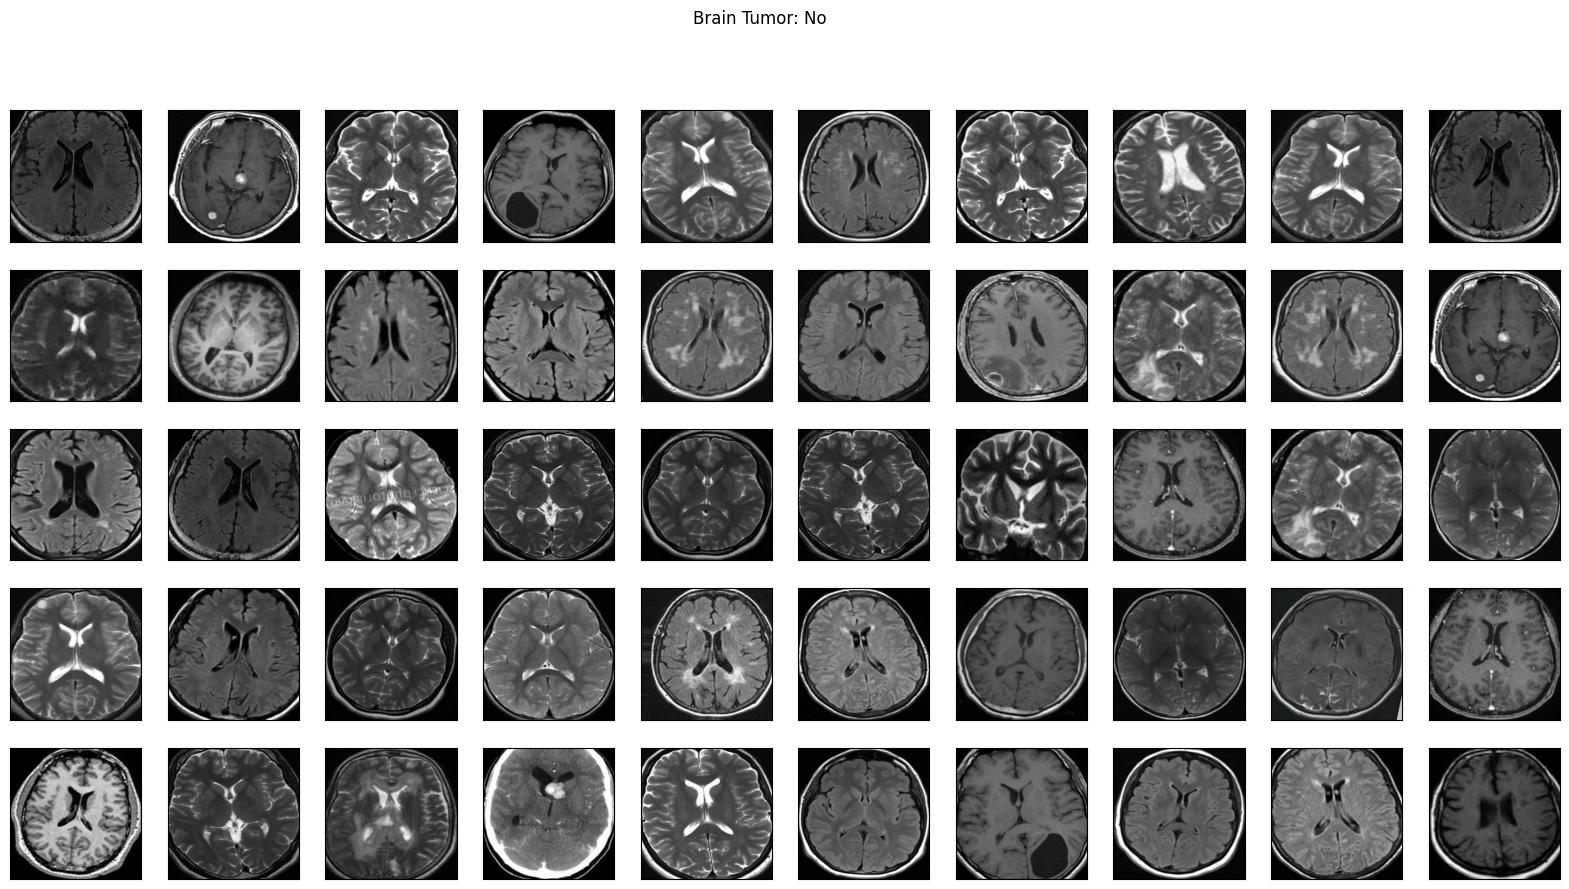

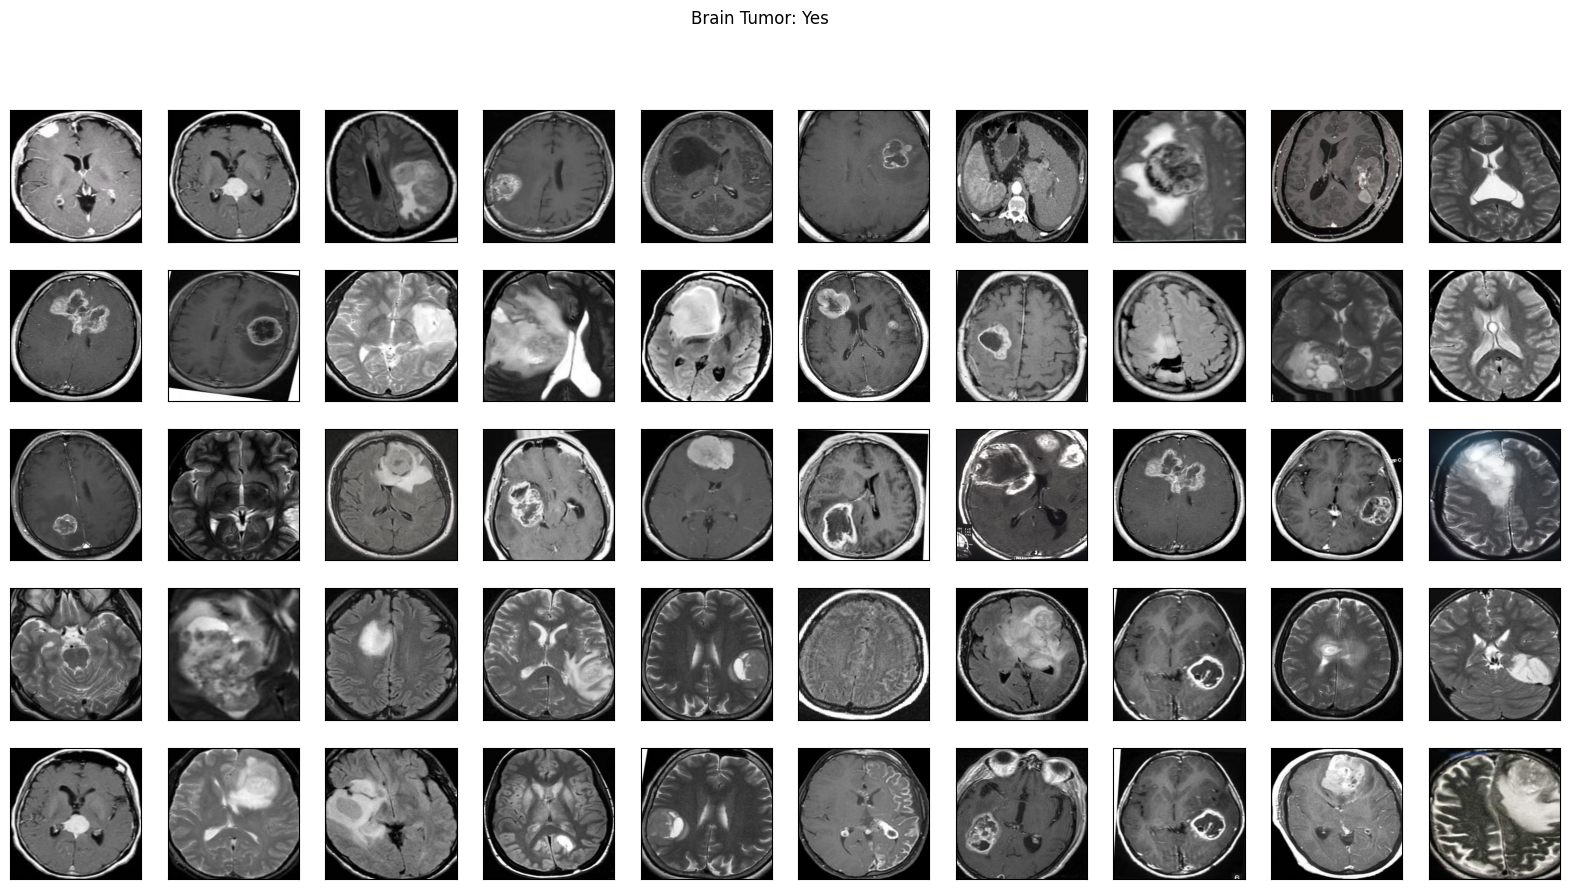

In [21]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [22]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [24]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1206
number of development examples = 259
number of test examples = 259
X_train shape: (1206, 240, 240, 3)
Y_train shape: (1206, 1)
X_val (dev) shape: (259, 240, 240, 3)
Y_val (dev) shape: (259, 1)
X_test shape: (259, 240, 240, 3)
Y_test shape: (259, 1)


Some helper functions:

In [25]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [26]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [27]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [28]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [29]:
model = build_model(IMG_SHAPE)

In [30]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [51]:
# [46]:
# unique file name that will include the epoch and the validation (development) accuracy
# CHANGE .model to .keras
filepath='cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras'

# save the model with the best validation (development) accuracy till now
# Change the ModelCheckpoint call to use the correct full filename
checkpoint = ModelCheckpoint(
    'models/{}'.format(filepath),  # Use the full filename template here
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

## Train the model

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.5754 - loss: 0.9746
Epoch 1: val_accuracy improved from None to 0.64865, saving model to models1/cnn-model1-0001.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 813ms/step - accuracy: 0.6227 - loss: 0.8188 - val_accuracy: 0.6486 - val_loss: 0.6424
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.7404 - loss: 0.5242
Epoch 2: val_accuracy did not improve from 0.64865
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 796ms/step - accuracy: 0.7521 - loss: 0.5140 - val_accuracy: 0.6486 - val_loss: 0.6248
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.7878 - loss: 0.4369
Epoch 3: val_accuracy improved from 0.64865 to 0.74517, saving model to models1/cnn-model1-0003.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 875ms/step - accuracy: 0.8051 - loss: 0.4072 - val_accuracy: 0.7452 - val_loss: 0.5718
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8687 - loss: 0.3405
Epoch 4: val_accuracy improved from 0.74517 to 0.7

Let's train for a few more epochs:

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9541 - loss: 0.1353
Epoch 1: val_accuracy did not improve from 0.85328
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 809ms/step - accuracy: 0.9527 - loss: 0.1420 - val_accuracy: 0.8494 - val_loss: 0.3530
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9670 - loss: 0.1204
Epoch 2: val_accuracy improved from 0.85328 to 0.86486, saving model to models1/cnn-model1-0002.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 785ms/step - accuracy: 0.9627 - loss: 0.1258 - val_accuracy: 0.8649 - val_loss: 0.2765
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9605 - loss: 0.1270
Epoch 3: val_accuracy did not improve from 0.86486
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 792ms/step - accuracy: 0.9594 - loss: 0.1313 - val_accuracy: 0.8263 - val_loss: 0.4142
Elapsed time: 0:1:31.8


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 438s 303ms/step - loss: 0.1471 - acc: 0.9612 - val_loss: 0.3190 - val_acc: 0.8903
Epoch 2/3
1445/1445 [==============================] - 432s 299ms/step - loss: 0.1384 - acc: 0.9564 - val_loss: 0.3509 - val_acc: 0.8613
Epoch 3/3
1445/1445 [==============================] - 429s 297ms/step - loss: 0.1240 - acc: 0.9647 - val_loss: 0.3358 - val_acc: 0.8710
Elapsed time: 0:21:38.5


In [43]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9891 - loss: 0.0663
Epoch 1: val_accuracy did not improve from 0.91506
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 823ms/step - accuracy: 0.9867 - loss: 0.0678 - val_accuracy: 0.9151 - val_loss: 0.2722
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9897 - loss: 0.0548
Epoch 2: val_accuracy improved from 0.91506 to 0.91892, saving model to models1/cnn-model1-0002.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 809ms/step - accuracy: 0.9925 - loss: 0.0517 - val_accuracy: 0.9189 - val_loss: 0.3146
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9947 - loss: 0.0427
Epoch 3: val_accuracy did not improve from 0.91892
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 824ms/step - accuracy: 0.9934 - loss: 0.0455 - val_accuracy: 0.9189 - val_loss: 0.3071
Elapsed time: 0:1:44.7


In [42]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9733 - loss: 0.1021
Epoch 1: val_accuracy improved from 0.86486 to 0.87645, saving model to models1/cnn-model1-0001.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 861ms/step - accuracy: 0.9718 - loss: 0.1038 - val_accuracy: 0.8764 - val_loss: 0.2982
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9849 - loss: 0.0829
Epoch 2: val_accuracy did not improve from 0.87645
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 893ms/step - accuracy: 0.9809 - loss: 0.0897 - val_accuracy: 0.8533 - val_loss: 0.3537
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9750 - loss: 0.0878
Epoch 3: val_accuracy improved from 0.87645 to 0.91506, saving model to models1/cnn-model1-0003.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 904ms/step - accuracy: 0.9793 - loss: 0.0850 - val_accuracy: 0.9151 - val_loss: 0.2628
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9707 - loss: 0.1059
Epoch 4: val_accuracy did not improve from 0.91506


In [41]:
history = model.history.history

In [38]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [39]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

In [40]:
plot_metrics(history)

KeyError: 'acc'

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [61]:
model = load_model('models/cnn-parameters-improvement-01-0.50.h5')

TypeError: Error when deserializing class 'Conv2D' using config={'name': 'conv0', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: <class 'keras.src.initializers.random_initializers.VarianceScaling'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.initializers', 'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None, 'dtype': 'float32'}, 'registered_name': None}.

Exception encountered: VarianceScaling.__init__() got an unexpected keyword argument 'dtype'

In [57]:
from keras.models import load_model
# This will only work if the file contents are actually in H5 format
try:
    best_model = load_model(filepath='models/cnn-parameters-improvement-01-0.50.h5')
    print("Model loaded successfully as H5.")
except Exception as e:
    print(f"Loading as H5 failed: {e}")
    # Revert to TFSMLayer approach

Loading as H5 failed: Error when deserializing class 'Conv2D' using config={'name': 'conv0', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: <class 'keras.src.initializers.random_initializers.VarianceScaling'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

confi

In [58]:
# Assuming you are in the *old* environment with the correct Keras/TF version

# 1. Load the model in the old environment
old_model = tf.keras.models.load_model('models/cnn-parameters-improvement-01-0.50.model')

# 2. Save it in the new Keras V3 format
old_model.save('best_model.keras') 

best_model = load_model(filepath='best_model.keras')

ValueError: File format not supported: filepath=models/cnn-parameters-improvement-01-0.50.model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(models/cnn-parameters-improvement-01-0.50.model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [56]:
best_model.metrics_names

NameError: name 'best_model' is not defined

Evaluate the best model on the testing data:

In [73]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 18s 57ms/step


### Accuracy of the best model on the testing data:

In [74]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.33390871454631127
Test Accuracy = 0.8870967741935484


### F1 score for the best model on the testing data:

In [75]:
y_test_prob = best_model.predict(X_test)

In [76]:
f1score = compute_f1_score(y_test, y_test_prob)
 print(f"F1 score: {f1score}")

F1 score: 0.8829431438127091


Let's also find the f1 score on the validation data:

In [83]:
y_val_prob = best_model.predict(X_val)

In [85]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9123867069486403


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [77]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [81]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [79]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.8719723183391%, number of pos examples: 764
Percentage of negative examples: 47.1280276816609%, number of neg examples: 681
Validation Data:
Number of examples: 310
Percentage of positive examples: 54.83870967741935%, number of pos examples: 170
Percentage of negative examples: 45.16129032258065%, number of neg examples: 140
Testing Data:
Number of examples: 310
Percentage of positive examples: 48.70967741935484%, number of pos examples: 151
Percentage of negative examples: 51.29032258064516%, number of neg examples: 159


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!